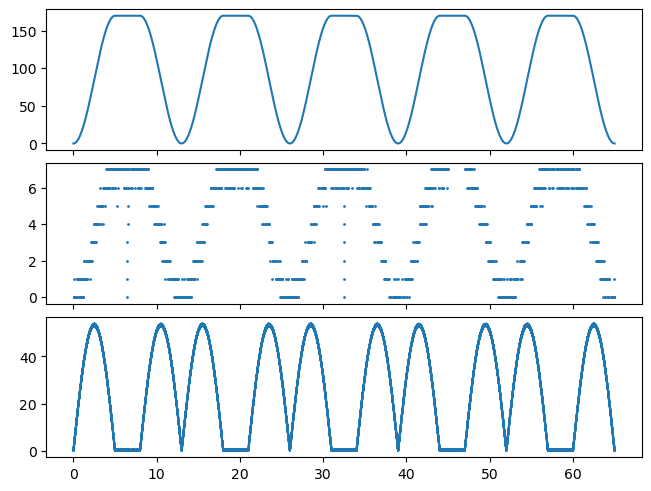

In [1]:
from src.simulate import make_simulated_data
import matplotlib.pyplot as plt
import numpy as np

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

spikes[(time > 45) & (time < 47)] = 0.0
# spikes[np.logical_and(speed > 30.0, speed < 40.0)] = 0.0

is_ripple = np.zeros_like(time, dtype=bool)
for ripple_time in ripple_times:
    is_ripple |= (time >= ripple_time[0]) & (time <= ripple_time[1])


fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)


In [2]:
from replay_trajectory_classification import Environment

env = Environment(place_bin_size=2.0).fit_place_grid(position[:, None])


Cupy is not installed or GPU is not detected. Ignore this message if not using GPU


In [3]:
speed_knots = [0.5, 4.0, 20.0]


In [4]:
from src.test_non_local_switching_non_stationary_model import (
    setup_nonlocal_switching_model,
)

(
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    continuous_state_transitions,
    state_ind,
    no_spike_rates,
    is_training,
    state_names,
) = setup_nonlocal_switching_model(
    is_ripple,
    spikes,
    position,
    speed,
    env,
    sampling_frequency=sampling_frequency,
    speed_knots=speed_knots,
    is_stationary_discrete_transition=True,
    no_spike_rate_threshold=1e1,
    no_spike_rate=1e-10,
    is_no_spike_transition_constant=True,
    include_no_spike_state=True,
)


In [5]:
discrete_state_transitions.shape

(3, 3)

In [6]:
discrete_state_transitions.sum(axis=-1)

array([1., 1., 1.])

In [7]:
from patsy import build_design_matrices
import numpy as np
from src.hmm import centered_softmax_forward


if discrete_transition_design_matrix is not None:
    predict_data = {"speed": np.arange(0, 50.0)}
    predict_matrix = build_design_matrices(
        [discrete_transition_design_matrix.design_info], predict_data
    )[0]


    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))

    for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
        from_local_transition = centered_softmax_forward(
            predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
        )

        ax.plot(predict_data["speed"], from_local_transition)
        ax.set_xlabel("Speed")
        ax.set_ylabel("Prob.")
        ax.legend(state_names)
        ax.set_title(f"From {from_state}")
        
    plt.ylim((0, 1.01))

In [8]:
from src.test_non_local_switching_non_stationary_model import fit_switching_model

stickiness = np.zeros((3,1))
stickiness[1] = 70.0

(
    predicted_state,
    acausal_posterior,
    acausal_state_probabilities,
    causal_posterior,
    marginal_log_likelihoods,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    non_local_rates,
) = fit_switching_model(
    spikes,
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    continuous_state_transitions,
    state_ind,
    no_spike_rates,
    is_training,
    env,
    discrete_transition_coefficients=discrete_transition_coefficients,
    discrete_transition_design_matrix=discrete_transition_design_matrix,
    max_iter=100,
    fit_inital_conditions=True,
    fit_discrete_transition=True,
    fit_likelihood=False,
    is_no_spike_transition_constant=False,
    concentration=1.1,
    stickiness=stickiness,
)


[[9.98459695e-01 1.50607565e-03 3.42289920e-05]
 [5.00000000e-04 9.99000000e-01 5.00000000e-04]
 [6.66666667e-03 1.00000000e-16 9.93333333e-01]]
Likelihoods


  0%|          | 0/8 [00:00<?, ?it/s]

Expectation Step
Maximization Step
Stats
iteration 1, likelihood: -2035.4386407628288
[[9.96525022e-01 3.40722457e-03 6.77532124e-05]
 [5.96728612e-05 9.99913966e-01 2.63610910e-05]
 [1.16400815e-02 4.54799864e-04 9.87905119e-01]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 2, likelihood: -1958.1722123875504, change: 77.26642837527834
[[9.96903852e-01 2.93538997e-03 1.60757879e-04]
 [1.89150047e-05 9.99974054e-01 7.03138622e-06]
 [1.43427682e-02 2.92554145e-03 9.82731690e-01]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 3, likelihood: -1954.0689501108382, change: 4.1032622767122575
[[9.97522828e-01 2.21600420e-03 2.61167344e-04]
 [8.82489557e-06 9.99987352e-01 3.82267331e-06]
 [1.92092329e-02 7.58889253e-03 9.73201875e-01]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 4, likelihood: -1953.2027539507135, change: 0.866196160124673
[[9.98133288e-01 1.56135397e-03 3.05358529e-04]
 [6.92970009e-06 9.99989548e-01 3.52229376e-06]
 [2.762

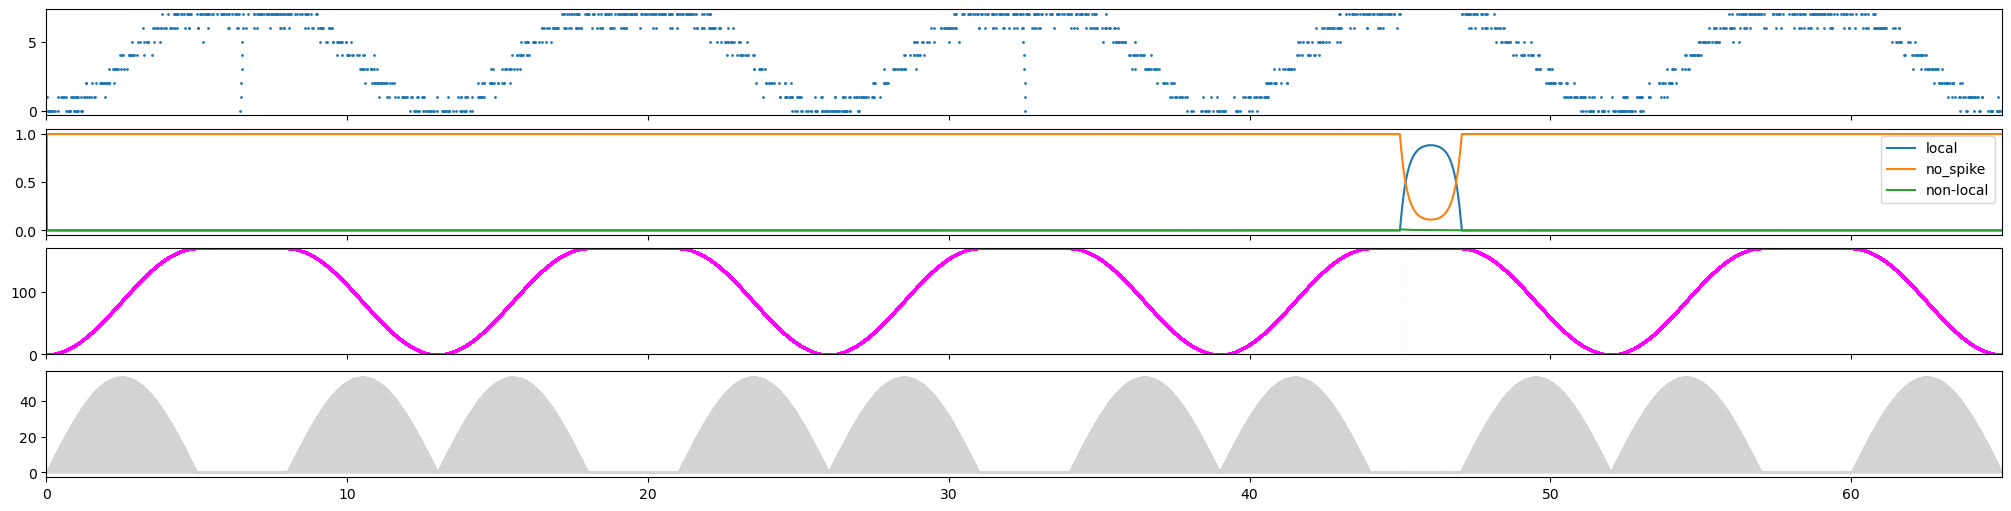

In [9]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(0, len(time)),
    figsize=(20, 5)
)


In [10]:
discrete_state_transitions[0, 0]

0.9987466423261002

In [11]:
discrete_state_transitions[1, 1]

0.9999866461403717

In [12]:
discrete_state_transitions[2, 2]

0.9227075213659116

In [13]:
from patsy import build_design_matrices
import numpy as np
from src.hmm import centered_softmax_forward


if discrete_transition_design_matrix is not None:
    predict_data = {"speed": np.arange(0, 50.0)}
    predict_matrix = build_design_matrices(
        [discrete_transition_design_matrix.design_info], predict_data
    )[0]


    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))

    for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
        from_local_transition = centered_softmax_forward(
            predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
        )

        ax.plot(predict_data["speed"], from_local_transition)
        ax.set_xlabel("Speed")
        ax.set_ylabel("Prob.")
        ax.legend(state_names)
        ax.set_title(f"From {from_state}")
        
    plt.ylim((0, 1.01))
